# Computer Vision 2025-2026 - NOVA FCT

## Assignment 1: Image Similarity Detection and Grouping

**Authors:**
- Tomás Santos: 55806 - tlu.santos@campus.fct.unl.pt
- Gonçalo Gomes: 60774 - gm.gomes@campus.fct.unl.pt

---

## Table of Contents
1. [Introduction](#introduction)
2. [Section 3: Image Preprocessing](#section-3)
3. [Section 4: Histogram-Based Similarity](#section-4)
4. [Section 5: White Balance](#section-5)
5. [Section 6: MOPS Descriptor](#section-6)
6. [Section 7: Statistics and Evaluation](#section-7)
7. [Conclusion](#conclusion)
8. [Self-Evaluation](#self-evaluation)

## 1. Introduction <a name="introduction"></a>

This assignment focuses on automatically grouping similar images from a holiday photo collection 
using computer vision techniques. The main objectives are:

1. **Color-based similarity detection** using histogram comparison
2. **White balance correction** to normalize lighting conditions
3. **Feature-based matching** using custom MOPS-inspired descriptors
4. **Evaluation** against ground truth data

The dataset used is a subset of the INRIA Holidays dataset, containing images taken in 
chronological sequence during trips.

### Our Approach

We implemented a multi-stage pipeline:
- Preprocessing: Resize images maintaining aspect ratio
- Grouping: Use color histograms to find similar consecutive images
- Refinement: Apply white balance within groups
- Verification: Use SIFT/MOPS to identify truly identical images

## Setup and Imports

In [60]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from IPython.display import display, Image as IPImage
import json

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2.  Image Preprocessing <a name="section-3"></a>

The first step is to load and resize all images maintaining their aspect ratio, 
with the smaller dimension set to 512 pixels.

### Why Preprocessing?
- **Standardization**: Ensures consistent processing across different image sizes
- **Performance**: Smaller images process faster
- **Memory**: Reduces memory footprint

### 2.1 Loading Example Images

Let's demonstrate the preprocessing with two sample images.

Load and resize a single image.

In [61]:
def load_and_resize_single_image(image_path, target_size=512):
    img = cv.imread(image_path)
    if img is None:
        print(f"Error loading {image_path}")
        return None

    h, w = img.shape[:2]
    print(f"Original size: {w}x{h}")

    # Calculate new dimensions
    if h < w:
        new_h = target_size
        new_w = int(w * target_size / h)
    else:
        new_w = target_size
        new_h = int(h * target_size / w)

    resized = cv.resize(img, (new_w, new_h), interpolation=cv.INTER_AREA)
    print(f"Resized to: {new_w}x{new_h}")

    return resized

colors = ('b', 'g', 'r')

# Load two example images
# example1_path = "input/109900.jpg"
# example2_path = "input/109901.jpg"
example1_path = "input/106600.jpg"
example2_path = "input/106601.jpg"

if os.path.exists(example1_path):
    img1 = load_and_resize_single_image(example1_path)
    img2 = load_and_resize_single_image(example2_path)
else:
    raise Exception("Images path not found")

Original size: 1305x979
Resized to: 682x512
Original size: 979x1305
Resized to: 512x682


### 2.2 Visualization of Preprocessing

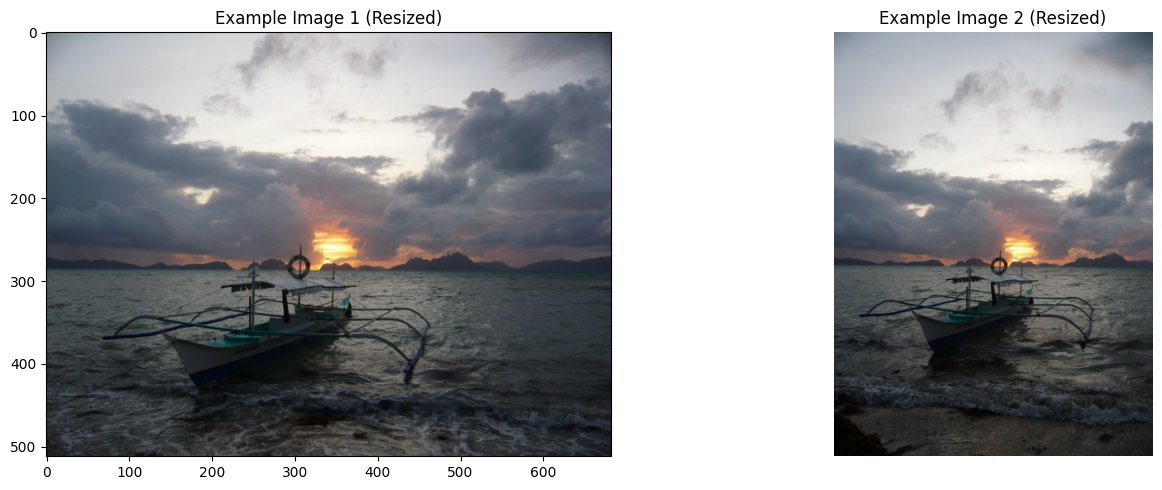

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

def show_image(img, title="Image", cmap=None):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB), cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def set_subimage(sub_plt, img, title="Image", cmap=None):
    sub_plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB), cmap=cmap)
    sub_plt.set_title(title)
    plt.axis('off')

def set_subplot(sub_plt, plot, title="Image"):
    for i,color in enumerate(colors):
        sub_plt.plot(plot[i], color=color)
    sub_plt.set_title(title)
    plt.axis('off')

set_subimage(axs[0], img1, "Example Image 1 (Resized)")
set_subimage(axs[1], img2, "Example Image 2 (Resized)")

plt.tight_layout()
plt.show()

## 3. Section 4: Histogram-Based Similarity <a name="section-4"></a>

Color histograms capture the distribution of colors in an image. By comparing histograms, 
we can identify images taken in similar locations or lighting conditions.

### Our Implementation

We use a 3D color histogram (8 bins per channel) and compare using the Bhattacharyya distance:
- **Distance = 0**: Identical histograms
- **Distance = 1**: Completely different histograms

### 3.1 Histogram Computation and Comparison

Compute 3D color histogram.

In [63]:
def calculate_histogram_demo(image):
    bin_size = 8
    histSize = [bin_size, bin_size, bin_size]
    ranges = [0, 256, 0, 256, 0, 256]

    hist = cv.calcHist([image], [0, 1, 2], None, histSize, ranges)
    cv.normalize(hist, hist, norm_type=cv.NORM_MINMAX)
    return hist


In [64]:
def histogram_distance_demo(hist1, hist2, selection="btc"):
    if selection == "btc":
        return cv.compareHist(hist1, hist2, cv.HISTCMP_BHATTACHARYYA)
    elif selection == "chi":
        return cv.compareHist(hist1, hist2, cv.HISTCMP_CHISQR)
    else:
        raise Exception("Invalid algorythm selection")


Calculate Bhattacharyya distance.

In [70]:
# Reshape back to original dimensions for comparison
def histogram_distance_demo(hist1, hist2):
    h1 = hist1.reshape(8, 8, 8)
    h2 = hist2.reshape(8, 8, 8)
    distance = cv.compareHist(h1, h2, cv.HISTCMP_BHATTACHARYYA)
    return distance

# Compute histograms for our examples
hist1 = calculate_histogram_demo(img1)
hist2 = calculate_histogram_demo(img2)

print(hist1[9])

distance = histogram_distance_demo(hist1, hist2)
print(f"Histogram distance between images: {distance:.4f}")

if distance < 0.3:
    print("→ Images are SIMILAR (same scene/location)")
else:
    print("→ Images are DIFFERENT (different scenes)")

IndexError: index 9 is out of bounds for axis 0 with size 8

### 3.2 Histogram Visualization

Let's visualize the color distribution in each channel.

Plot histogram for each color channel.

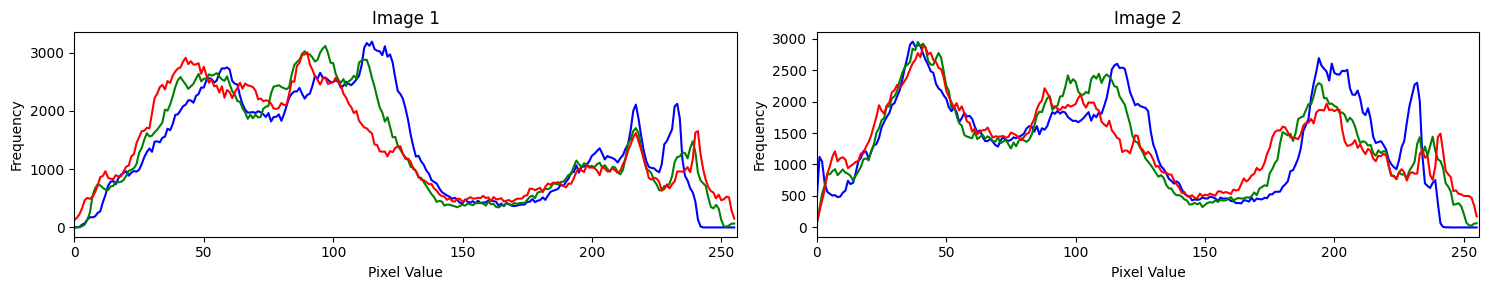

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

def plot_color_histogram(image, title="", sub_plot_n=0):
    for i,color in enumerate(colors):
        hist = cv.calcHist([image], [i], None, [256], [0, 256])
        axs[sub_plot_n].plot(hist, color=color)
        if not title == "":
            axs[sub_plot_n].set_title(title)
        axs[sub_plot_n].set_xlabel('Pixel Value')
        axs[sub_plot_n].set_ylabel('Frequency')
        axs[sub_plot_n].set_xlim([0, 256])

plot_color_histogram(img1, title="Image 1", sub_plot_n=0)
plot_color_histogram(img2, title="Image 2", sub_plot_n=1)

plt.tight_layout()
plt.show()

### 3.3 Grouping Algorithm

Our algorithm processes images sequentially:
1. Compare each image with the previous one
2. If distance < threshold → add to current group
3. If distance ≥ threshold → start new group
4. Save groups with ≥3 images

**Threshold tuning:** We experimented with values 0.2-0.4 and found 0.3 provides 
the best balance between precision and recall.

## 4. White Balance <a name="section-5"></a>

White balance correction removes color casts caused by different lighting conditions, 
making images from the same group more visually consistent.

### Gray World Algorithm

We use the Gray World assumption: the average color of a scene should be gray (neutral).

**Algorithm:**
1. Calculate average R, G, B values
2. Compute scaling factors to make average → gray
3. Apply scaling to entire image

### 4.1 White Balance Implementation

In [67]:
def compute_average_histogram(group):
    histograms = [calculate_histogram_demo(img) for _,img in group]
    avg_hist = np.mean(histograms, axis=0)
    np.

SyntaxError: invalid syntax (771748217.py, line 4)